<center> <h2><b>Machine Learning for Healthcare, Project 1: Time-Series</b></h2> </center>
<h3><b>Intensive Care Time Series Modeling for Mortality Predictions on 
the Physionet 2012 Challenge Dataset </b></h3>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

### **1. Data Processing and Exploration (5 Pts)**
#### Q1.1: Data Transformation (1 Pts) 

In [2]:
def parse_data(dataset):
    """
    Parses the data from the given dataset directory and saves it as a parquet file.

    Parameters:
    dataset (str): The path to the dataset directory.

    Returns:
    None
    """
    filename = dataset[5:] + '.parquet'

    # If the file already exists, delete it and create a new one
    if os.path.exists(filename):
        os.remove(filename)

    # Read and compile all files in the directory
    txt_all = []
    for f in os.listdir(dataset):
        with open(os.path.join(dataset, f), 'r') as fp:
            txt = fp.readlines()

        # Get recordid to add as a column
        recordid = txt[1].rstrip('\n').split(',')[-1]
        txt = [t.rstrip('\n').split(',') + [int(recordid)] for t in txt]
        txt_all.extend(txt[1:])

    # Create DataFrame
    df = pd.DataFrame(txt_all, columns=['time', 'parameter', 'value', 'recordid'])
    df = df[df.parameter != 'RecordID']

    # Convert 'time' to hours and minutes and then to total minutes
    def time_to_minutes(time_str):
        hours, minutes = map(int, time_str.split(':'))
        return hours * 60 + minutes

    df['time_minutes'] = df['time'].apply(time_to_minutes)

    # Round up to the nearest hour
    df['time'] = ((df['time_minutes'] + 59) // 60).clip(upper=48)

    # Keep the most recent value by sorting and dropping duplicates
    df.sort_values(by=['recordid', 'time', 'time_minutes'], ascending=[True, True, False], inplace=True)
    df.drop_duplicates(subset=['recordid', 'time', 'parameter'], keep='first', inplace=True)

    # Pivot the DataFrame
    df_pivot = df.pivot_table(index=['recordid', 'time'], columns='parameter', values='value', aggfunc='first').reset_index()

    # Ensure all patients have 49 rows (0 to 48 hours)
    all_hours = pd.DataFrame({'time': range(49)})

    patients = df['recordid'].unique()
    patient_hours = pd.MultiIndex.from_product([patients, all_hours['time']], names=['recordid', 'time'])

    # Reindex to include all patient-hour combinations
    final_df = df_pivot.set_index(['recordid', 'time']).reindex(patient_hours).reset_index()

    # Convert time column into timesteps
    final_df['time'] = final_df['time'].apply(lambda x: f'{x:02}:00')

    static_columns = ["Age", "Gender", "Height", "ICUType", "Weight"]

    # Remove -1 values and propagate the static values to all the rows
    for col in static_columns:
        final_df[col] = final_df[col].astype(float).replace(-1, np.nan)
        final_df[col] = final_df.groupby('recordid')[col].transform(lambda x: x.ffill().bfill())
    
    for col in final_df.columns:
        try:
            final_df[col] = pd.to_numeric(final_df[col], errors='raise')
            # If all values are integers, convert to int
            if final_df[col].apply(float.is_integer).all():
                final_df[col] = final_df[col].astype(int)
        except:
            pass  # Keep as is if conversion fails

    # Fill None missing values with NaN
    final_df = final_df.fillna(value=np.nan)

    final_df.to_parquet(filename, index=False)

def extract_labels(outcome):
    """
    Extracts the labels from the given outcome file and saves it as a parquet file.

    Parameters:
    outcome (str): The path to the outcome file.

    Returns:
    None
    """
    filename = outcome[5:-4].lower() + '.parquet'

    # If the file already exists, delete it and create a new one
    if os.path.exists(filename):
        os.remove(filename)

    with open(outcome, 'r') as fp:
        txt = fp.readlines()
    
    labels = []
    for line in txt[1:]:  # Skip header
        parts = line.strip().split(',')
        recordid = int(parts[0])
        in_hospital_death = int(parts[-1])
        labels.append((recordid, in_hospital_death))

    labels_df = pd.DataFrame(labels, columns=['recordid', 'in_hospital_death'])
    labels_df.to_parquet(filename, index=False)

In [3]:
# For the notebook to run, we suppose the data is inside a 'data' folder
dataset_paths = ['data/set-a', 'data/set-b', 'data/set-c']
outcome_paths = ['data/Outcomes-a.txt', 'data/Outcomes-b.txt', 'data/Outcomes-c.txt']

# Only need to run once
# for dataset in dataset_paths:
#     parse_data(dataset)

# for outcome in outcome_paths:
#     extract_labels(outcome)

# Read the parsed data saved as parquet files
X_set_a, X_set_b, X_set_c = pd.read_parquet('set-a.parquet'), pd.read_parquet('set-b.parquet'), pd.read_parquet('set-c.parquet')
Y_set_a, Y_set_b, Y_set_c = pd.read_parquet('outcomes-a.parquet'), pd.read_parquet('outcomes-b.parquet'), pd.read_parquet('outcomes-c.parquet')

# From X_set_c drop unnamed parameter column
X_set_c = X_set_c.drop(columns='')

print(X_set_a.shape, X_set_b.shape, X_set_c.shape)
print(Y_set_a.shape, Y_set_b.shape, Y_set_c.shape)

(196000, 43) (196000, 43) (196000, 43)
(4000, 2) (4000, 2) (4000, 2)


In [4]:
X_set_a

recordid   time  ALP  ALT  AST  Age  Albumin  BUN  Bilirubin  \
0         132539  00:00  NaN  NaN  NaN   54      NaN  NaN        NaN   
1         132539  01:00  NaN  NaN  NaN   54      NaN  NaN        NaN   
2         132539  02:00  NaN  NaN  NaN   54      NaN  NaN        NaN   
3         132539  03:00  NaN  NaN  NaN   54      NaN  NaN        NaN   
4         132539  04:00  NaN  NaN  NaN   54      NaN  NaN        NaN   
...          ...    ...  ...  ...  ...  ...      ...  ...        ...   
195995    142673  44:00  NaN  NaN  NaN   78      NaN  NaN        NaN   
195996    142673  45:00  NaN  NaN  NaN   78      NaN  NaN        NaN   
195997    142673  46:00  NaN  NaN  NaN   78      NaN  NaN        NaN   
195998    142673  47:00  NaN  NaN  NaN   78      NaN  NaN        NaN   
195999    142673  48:00  NaN  NaN  NaN   78      NaN  NaN        NaN   

        Cholesterol  ...  RespRate  SaO2  SysABP  Temp  TroponinI  TroponinT  \
0               NaN  ...       NaN   NaN     NaN   NaN        NaN        NaN   
1               NaN  ...      19.0   NaN     NaN  35.6        NaN        NaN   
2               NaN  ...      18.0   NaN     NaN   NaN        NaN        NaN   
3               NaN  ...      19.0   NaN     NaN   NaN        NaN        NaN   
4               NaN  ...      20.0   NaN     NaN  37.8        NaN        NaN   
...             ...  ...       ...   ...     ...   ...        ...        ...   
195995          NaN  ...       NaN  98.0   112.0  37.7        NaN        NaN   
195996          NaN  ...       NaN   NaN   108.0  37.6        NaN        NaN   
195997          NaN  ...       NaN   NaN   112.0   NaN        NaN        NaN   
195998          NaN  ...       NaN   NaN   121.0  37.3        NaN        NaN   
195999          NaN  ...       NaN   NaN   129.0   NaN        NaN        NaN   

        Urine  WBC  Weight    pH  
0         NaN  NaN     NaN   NaN  
1        60.0  NaN     NaN   NaN  
2        30.0  NaN     NaN   NaN  
3       170.0  NaN     NaN   NaN  
4        60.0  NaN     NaN   NaN  
...       ...  ...     ...   ...  
195995   25.0  NaN    87.3  7.34  
195996   25.0  NaN    87.3   NaN  
195997   23.0  NaN    87.3  7.31  
195998   40.0  NaN    87.3   NaN  
195999   30.0  NaN    87.3   NaN  

[196000 rows x 43 columns]

In [5]:
X_set_a[X_set_a["recordid"] == 132539]

recordid   time  ALP  ALT  AST  Age  Albumin   BUN  Bilirubin  \
0     132539  00:00  NaN  NaN  NaN   54      NaN   NaN        NaN   
1     132539  01:00  NaN  NaN  NaN   54      NaN   NaN        NaN   
2     132539  02:00  NaN  NaN  NaN   54      NaN   NaN        NaN   
3     132539  03:00  NaN  NaN  NaN   54      NaN   NaN        NaN   
4     132539  04:00  NaN  NaN  NaN   54      NaN   NaN        NaN   
5     132539  05:00  NaN  NaN  NaN   54      NaN   NaN        NaN   
6     132539  06:00  NaN  NaN  NaN   54      NaN   NaN        NaN   
7     132539  07:00  NaN  NaN  NaN   54      NaN   NaN        NaN   
8     132539  08:00  NaN  NaN  NaN   54      NaN   NaN        NaN   
9     132539  09:00  NaN  NaN  NaN   54      NaN   NaN        NaN   
10    132539  10:00  NaN  NaN  NaN   54      NaN   NaN        NaN   
11    132539  11:00  NaN  NaN  NaN   54      NaN  13.0        NaN   
12    132539  12:00  NaN  NaN  NaN   54      NaN   NaN        NaN   
13    132539  13:00  NaN  NaN  NaN   54      NaN   NaN        NaN   
14    132539  14:00  NaN  NaN  NaN   54      NaN   NaN        NaN   
15    132539  15:00  NaN  NaN  NaN   54      NaN   NaN        NaN   
16    132539  16:00  NaN  NaN  NaN   54      NaN   NaN        NaN   
17    132539  17:00  NaN  NaN  NaN   54      NaN   NaN        NaN   
18    132539  18:00  NaN  NaN  NaN   54      NaN   NaN        NaN   
19    132539  19:00  NaN  NaN  NaN   54      NaN   NaN        NaN   
20    132539  20:00  NaN  NaN  NaN   54      NaN   NaN        NaN   
21    132539  21:00  NaN  NaN  NaN   54      NaN   NaN        NaN   
22    132539  22:00  NaN  NaN  NaN   54      NaN   NaN        NaN   
23    132539  23:00  NaN  NaN  NaN   54      NaN   NaN        NaN   
24    132539  24:00  NaN  NaN  NaN   54      NaN   NaN        NaN   
25    132539  25:00  NaN  NaN  NaN   54      NaN   NaN        NaN   
26    132539  26:00  NaN  NaN  NaN   54      NaN   NaN        NaN   
27    132539  27:00  NaN  NaN  NaN   54      NaN   NaN        NaN   
28    132539  28:00  NaN  NaN  NaN   54      NaN   NaN        NaN   
29    132539  29:00  NaN  NaN  NaN   54      NaN   NaN        NaN   
30    132539  30:00  NaN  NaN  NaN   54      NaN   NaN        NaN   
31    132539  31:00  NaN  NaN  NaN   54      NaN   NaN        NaN   
32    132539  32:00  NaN  NaN  NaN   54      NaN   NaN        NaN   
33    132539  33:00  NaN  NaN  NaN   54      NaN   NaN        NaN   
34    132539  34:00  NaN  NaN  NaN   54      NaN   8.0        NaN   
35    132539  35:00  NaN  NaN  NaN   54      NaN   NaN        NaN   
36    132539  36:00  NaN  NaN  NaN   54      NaN   NaN        NaN   
37    132539  37:00  NaN  NaN  NaN   54      NaN   NaN        NaN   
38    132539  38:00  NaN  NaN  NaN   54      NaN   NaN        NaN   
39    132539  39:00  NaN  NaN  NaN   54      NaN   NaN        NaN   
40    132539  40:00  NaN  NaN  NaN   54      NaN   NaN        NaN   
41    132539  41:00  NaN  NaN  NaN   54      NaN   NaN        NaN   
42    132539  42:00  NaN  NaN  NaN   54      NaN   NaN        NaN   
43    132539  43:00  NaN  NaN  NaN   54      NaN   NaN        NaN   
44    132539  44:00  NaN  NaN  NaN   54      NaN   NaN        NaN   
45    132539  45:00  NaN  NaN  NaN   54      NaN   NaN        NaN   
46    132539  46:00  NaN  NaN  NaN   54      NaN   NaN        NaN   
47    132539  47:00  NaN  NaN  NaN   54      NaN   NaN        NaN   
48    132539  48:00  NaN  NaN  NaN   54      NaN   NaN        NaN   

    Cholesterol  ...  RespRate  SaO2  SysABP  Temp  TroponinI  TroponinT  \
0           NaN  ...       NaN   NaN     NaN   NaN        NaN        NaN   
1           NaN  ...      19.0   NaN     NaN  35.6        NaN        NaN   
2           NaN  ...      18.0   NaN     NaN   NaN        NaN        NaN   
3           NaN  ...      19.0   NaN     NaN   NaN        NaN        NaN   
4           NaN  ...      20.0   NaN     NaN  37.8        NaN        NaN   
5           NaN  ...      20.0   NaN     NaN   NaN        NaN        NaN   
6           NaN  ... 

In [6]:
Y_set_a

recordid  in_hospital_death
0       132539                  0
1       132540                  0
2       132541                  0
3       132543                  0
4       132545                  0
...        ...                ...
3995    142665                  0
3996    142667                  0
3997    142670                  0
3998    142671                  1
3999    142673                  0

[4000 rows x 2 columns]

#### Q1.2 Exploratory Data Analysis (2 Pts)

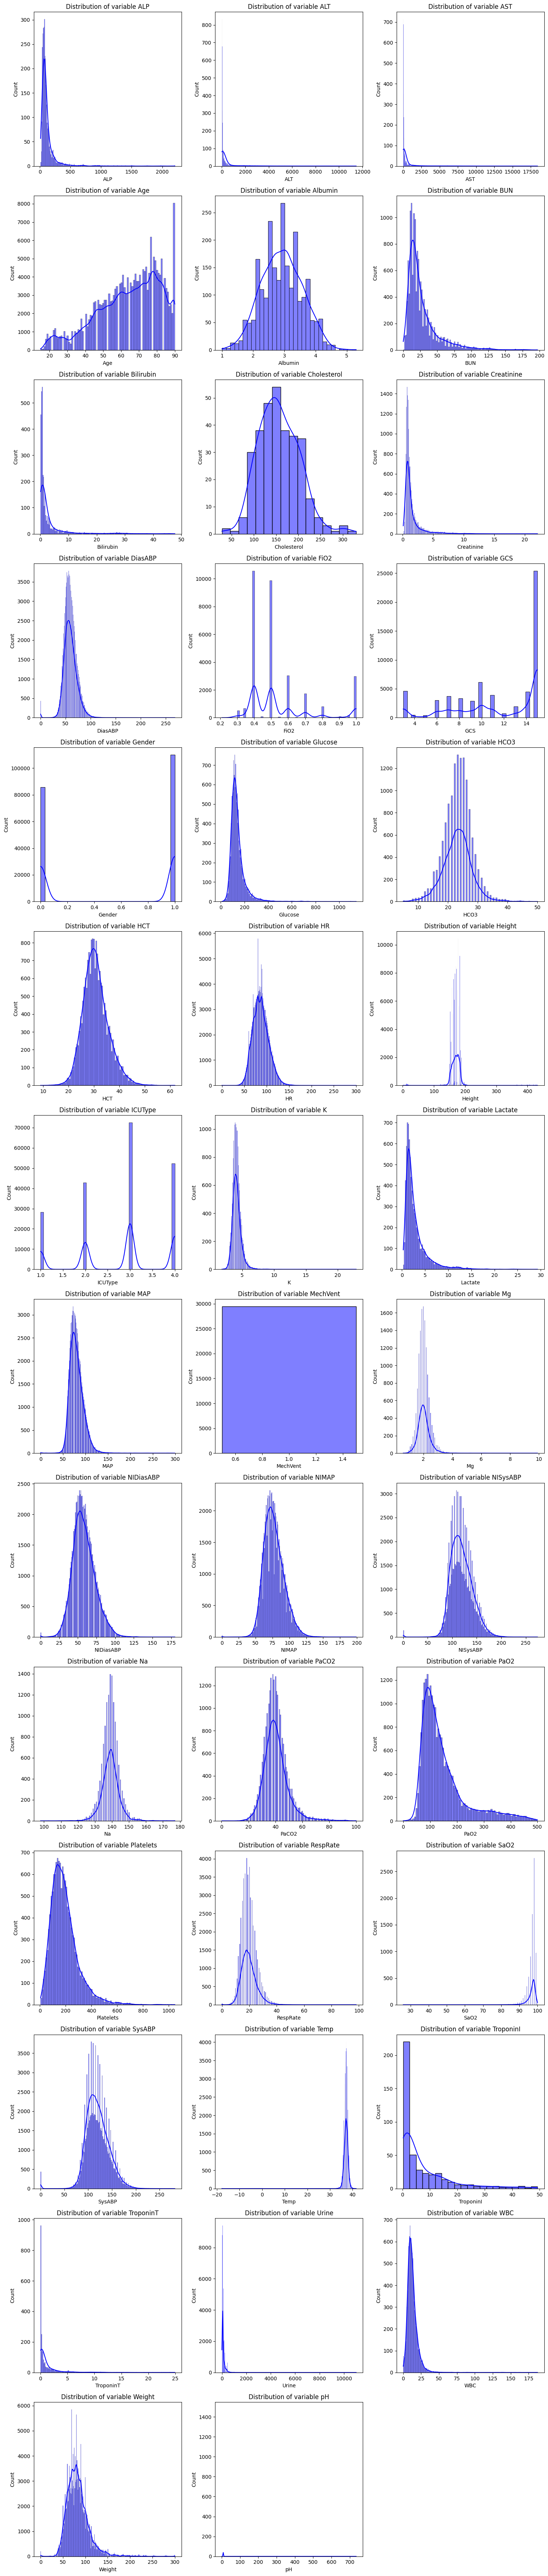

In [7]:
# Columns to exclude from the visualization plot
exclude_cols = ['time', 'recordid']

# Set up the plotting grid
cols_to_plot = [col for col in X_set_a.columns if col not in exclude_cols]
num_cols = len(cols_to_plot)
plt.figure(figsize=(15, 5 * (num_cols // 3 + 1)))

# Plot each column's distribution
plot_index = 1
for i, col in enumerate(cols_to_plot, 1):
    plt.subplot((num_cols // 3) + 1, 3, i)
    sns.histplot(pd.to_numeric(X_set_a[col]), kde=True, color='blue')
    plt.title(f"Distribution of variable {col}")

plt.tight_layout()
plt.show()

C:\Users\afons\AppData\Local\Temp\ipykernel_31360\3665346189.py:8: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
C:\Users\afons\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


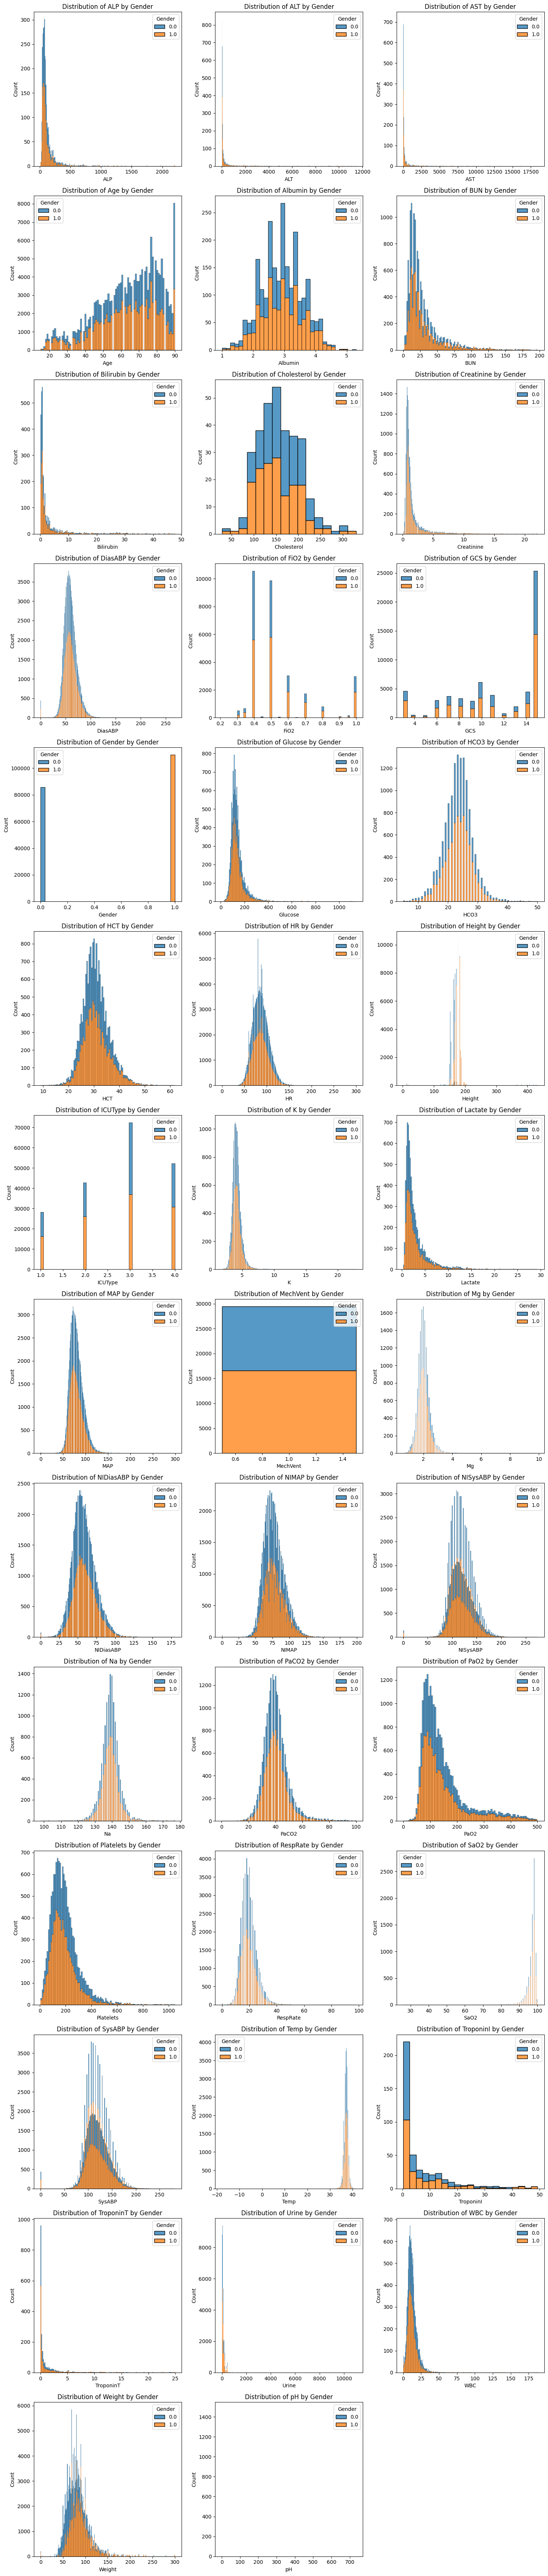

In [8]:
# Plot distributions by gender
plt.figure(figsize=(15, 5 * (num_cols // 3 + 1)))
for i, col in enumerate(cols_to_plot, 1):
    plt.subplot((num_cols // 3) + 1, 3, i)
    sns.histplot(data=X_set_a, x=col, hue='Gender', multiple='stack', color='skyblue')
    plt.title(f"Distribution of {col} by Gender")
    
plt.tight_layout()
plt.show()

C:\Users\afons\AppData\Local\Temp\ipykernel_31360\1162514536.py:12: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
C:\Users\afons\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


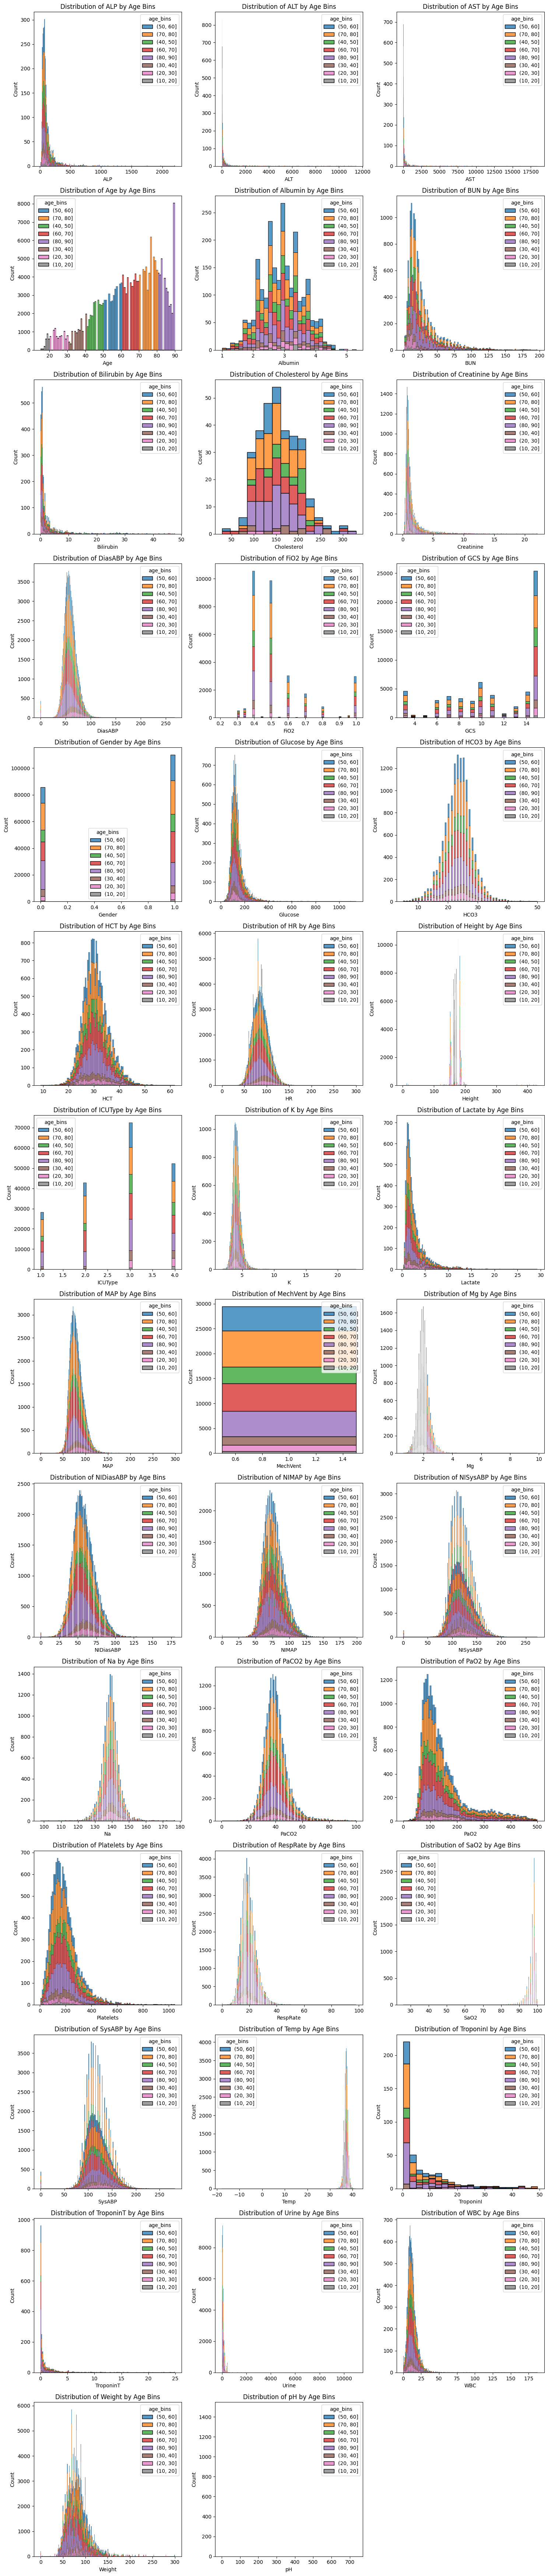

In [9]:
# Create Age Bins (10-year intervals)
X_set_a['age_bins'] = pd.cut(X_set_a['Age'], bins=np.arange(0, 100, 10))
X_set_a['age_bins'] = X_set_a['age_bins'].astype(str)

# Plot distributions by Age Bins
plt.figure(figsize=(15, 5 * (num_cols // 3 + 1)))
for i, col in enumerate(cols_to_plot, 1):
    plt.subplot(num_cols // 3 + 1, 3, i)
    sns.histplot(data=X_set_a, x=col, hue='age_bins', multiple='stack')
    plt.title(f"Distribution of {col} by Age Bins")

plt.tight_layout()
plt.show()

C:\Users\afons\AppData\Local\Temp\ipykernel_31360\3567940045.py:8: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
C:\Users\afons\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


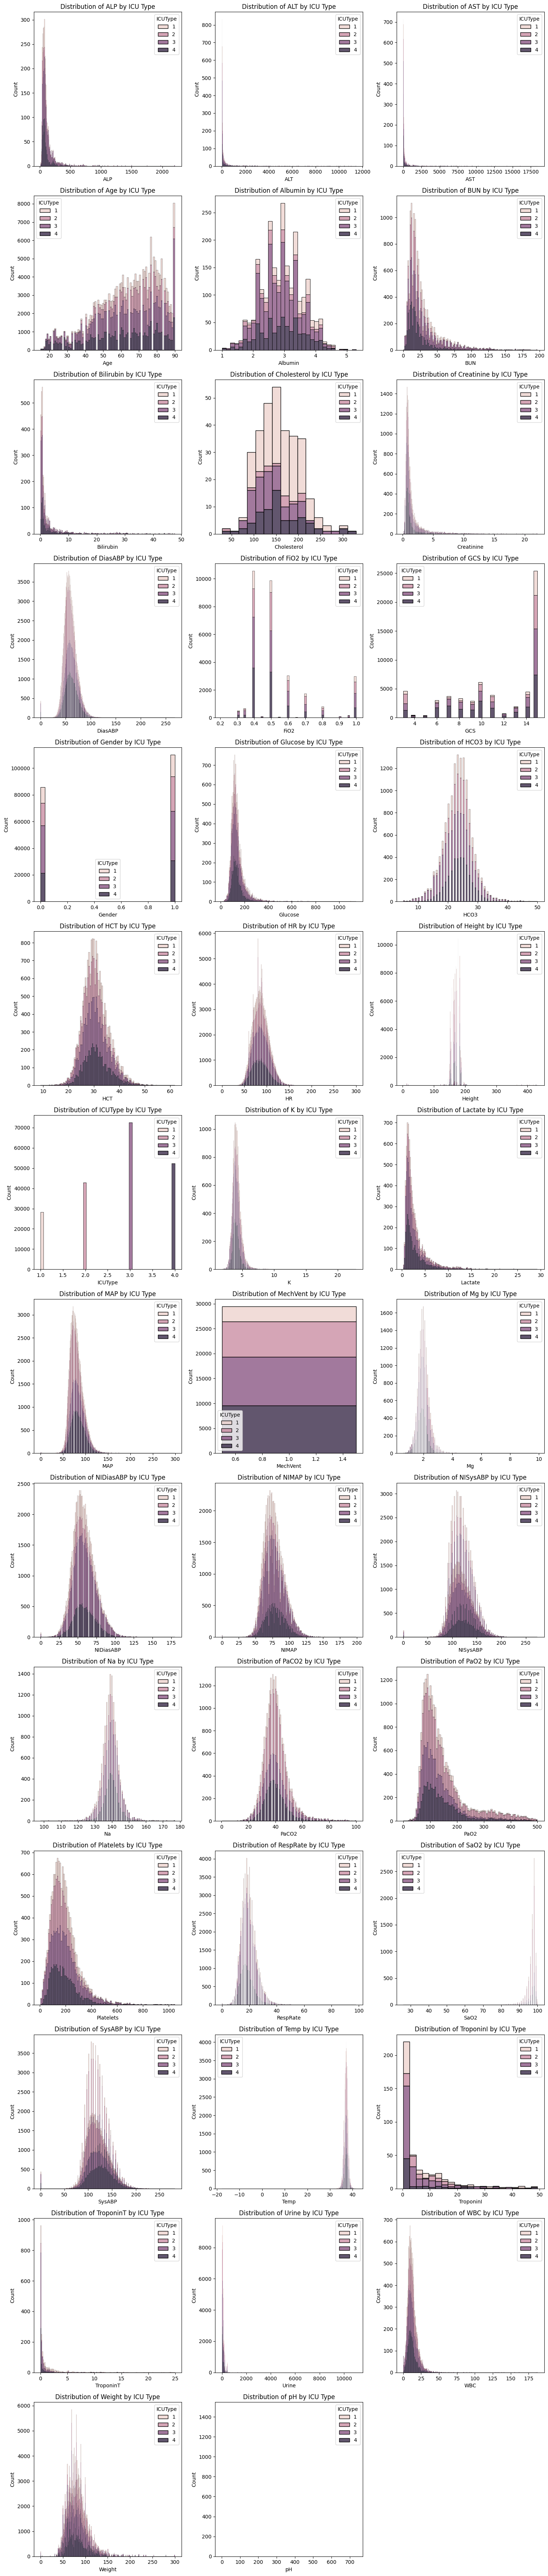

In [10]:
# Plot distributions by ICUType
plt.figure(figsize=(15, 5 * (num_cols // 3 + 1)))
for i, col in enumerate(cols_to_plot, 1):
    plt.subplot(num_cols // 3 + 1, 3, i)
    sns.histplot(data=X_set_a, x=col, hue='ICUType', multiple='stack')
    plt.title(f"Distribution of {col} by ICU Type")

plt.tight_layout()
plt.show()